In [117]:
import pandas as pd
import seaborn as sns
import numpy as np
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
import seaborn as sns
import csv

In [118]:

#Conditions: |, #, Number, APT
#suffixes = ['AVE', 'BLVD', 'CIR', 'CT', 'DR', 'LN', 'PKWY', 'PL', 'RD', 'ST', 'WAY']

def clean_address(address):
    splitters = {'|', '#', 'APT', 'ROOM'} 
    #'0', '1', '2', '3', '4', '5', '6', '7', '8', '9'}
    suffixes = {'AVE', 'BLVD', 'CIR', 'CT', 'DR', 'LN', 'PKWY', 'PL', 'RD', 'ST', 'WAY'}
    past_suffix = False

    split_address = address.split(' ')
    for i, s in enumerate(split_address):
        if s == '|':
            return ' '.join(split_address[i+1:])
        if s[0] == '#' or s in splitters:
            return ' '.join(split_address[:i])
    return address

# Test Cases
# print(clean_address('44 MOZART ST #P'))
# print(clean_address('RIDGECREST VILLAGE | 5120 WASHINGTON ST'))
# print(clean_address('720 BENNINGTON ST APT 208B'))
# print(clean_address('23 ABERDEEN ST ROOM 1-3'))
# print(clean_address('1840 COMMONWEALTH AVE'))

In [119]:
zillow = pd.read_csv('./data/all_listings.csv')

zillow = zillow[zillow['Address'].notna()]
#zillow[~zillow['Address'].str.contains('UNDISCLOSED ADDRESS')]
# zillow['Address'] = zillow['Address'].map(str)
# zillow['contains_adrs'] = zillow['Address'].str.contains('(UNDISCLOSED ADDRESS)', na=False)

zillow = zillow.drop(['Property URL', 'Country', 'Baths', 'State'], axis=1)
zillow['Address'] = zillow['Address'].str.upper()
zillow['Address'] = zillow['Address'].apply(lambda x: clean_address(x))
zillow[['Zip', 'Beds']] = zillow[['Zip', 'Beds']].astype('Int64')
zillow.head()


,Property type,Address,City,Zip,Beds,Rental Price (USD per month),Size,Size unit,Price per size unit (USD)
0,Apartment,44 MOZART ST,Jamaica Plain,2130,<NA>,200,0.0,sqft,NaN
1,Apartment,2 MONTFERN AVE,Brighton,<NA>,1,995,NaN,sqft,NaN
2,Apartment,571 WASHINGTON ST,Boston,2111,4,1095,100.0,sqft,10.95
3,Apartment,314 WARREN ST,Roxbury,2119,1,1200,0.0,sqft,NaN
4,Apartment,23 ABERDEEN ST,Boston,2215,<NA>,1200,0.0,sqft,NaN


In [120]:
padlong = pd.read_csv("./data/PAD.Long.2021.csv")

l = ["R1", "R2", "R3", "R4"]
padlong = padlong[padlong['FY2021.AV'].notna()]
padlong = padlong[padlong['FY2021.LU'].isin(l)]

padlong.drop(
    padlong.columns.difference(
        ['PID', 'ST_NAME', 'ST_NUM', 'ZIPCODE', 'FY2021.LU', 'FY2021.AV', 'DiffAV2021', 'X', 'Y', 
        #'CM_ID', 'Blk_ID_10' 
        ]
        ), 1, inplace=True)
padlong.rename(columns={'X': 'longitude', 'Y': 'latitude'}, inplace=True)
padlong["Address"] = padlong['ST_NUM'] + ' ' + padlong['ST_NAME']
#padlong[['X', 'Y']] = padlong[['X', 'Y']].round(5)
padlong['price_bracket'] = padlong['FY2021.AV'].apply(
    lambda x: '$1000000+' if len(str(x)) >= 9
    else '$'+str(int(round(x,-5))) + '-' + str(int(round(x,-5) + 100000)) if round(x,-5) < (round(x,-4))
    else '$'+str(int(round(x,-5) - 100000)) + '-' + str(int(round(x,-5))) if round(x,-5) > (round(x,-4)) 
    else None)


C:\Users\david\AppData\Local\Temp\ipykernel_19260\56049475.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  padlong.drop(


In [121]:
padlong.head()
print(len(padlong.index))


63718


In [122]:
inventory = pd.read_csv('./data/BuildingInventory.csv')
inventory = inventory.loc[inventory['use_class'] == 'Residential']
inventory = inventory[['pid_long', 'building_subtypology', 'sqft_class', 'unit_num', 'sqft', 'owner_list', 'env_recommendation_count']]
inventory.head()
print(len(inventory.index))

C:\Users\david\AppData\Local\Temp\ipykernel_19260\2597446351.py:1: DtypeWarning: Columns (1,53) have mixed types. Specify dtype option on import or set low_memory=False.
  inventory = pd.read_csv('./data/BuildingInventory.csv')


76993


In [123]:
all_properties = padlong.merge(inventory, left_on='PID', right_on='pid_long', how='outer')
all_properties.drop(['pid_long', 'ST_NUM', 'ST_NAME'], axis=1, inplace=True)
all_properties.drop_duplicates(inplace=True)
all_properties = all_properties[all_properties['owner_list'].notna()]
all_properties['rent_val'] = all_properties['FY2021.AV'].apply(lambda x: round(x, -4) * .01)
all_properties = all_properties[all_properties['rent_val'].notna()]
all_properties.sort_values('rent_val', ascending=False).head()
#print(len(all_properties.index))

,PID,ZIPCODE,FY2021.LU,FY2021.AV,DiffAV2021,longitude,latitude,Address,price_bracket,building_subtypology,sqft_class,unit_num,sqft,owner_list,env_recommendation_count,rent_val
58214,503270010,2116.0,R1,27977700.0,751000.0,-71.08037,42.35083,25 EXETER ST,$1000000+,"Single-Family, Pre-1915","< 25,000 sqft",NaN,21711.0,HYER LYNN,3.0,279800.0
58167,502826000,2116.0,R1,27858100.0,732700.0,-71.07249,42.35391,5 COMMONWEALTH AV,$1000000+,"Single-Family, Pre-1915","< 25,000 sqft",NaN,20326.0,FIVE COMMONWEALTH MORTGAGE,3.0,278600.0
58186,502896000,2116.0,R1,18030000.0,525400.0,-71.07837,42.35271,315 DARTMOUTH ST,$1000000+,"Single-Family, Pre-1915","< 25,000 sqft",NaN,13033.0,CASHMAN JAY M TS,3.0,180300.0
57733,501707000,2108.0,R3,17313500.0,504300.0,-71.06760,42.35843,85 MT VERNON ST,$1000000+,"Multi-Family (3 units), Pre-1915","< 25,000 sqft",NaN,14421.0,HEILBRONNER WARREN M TS,3.0,173100.0
57700,501651110,2108.0,R1,15733400.0,950200.0,-71.06846,42.35876,19 LOUISBURG SQ,$1000000+,"Single-Family, Pre-1915","< 25,000 sqft",NaN,8286.0,SMITH LINDA K,3.0,157300.0


In [124]:
rent_by_landlord = all_properties
rent_by_landlord = rent_by_landlord[['owner_list', 'rent_val']]

temp = rent_by_landlord['owner_list']
temp = temp.value_counts().to_frame().reset_index()
temp.rename(columns={'index': 'owner_list', 'owner_list': 'property_count'}, inplace=True)

rent_by_landlord['total_possible_income'] = rent_by_landlord.groupby('owner_list')['rent_val'].transform('sum')
rent_by_landlord['average_rent_price'] = rent_by_landlord.groupby('owner_list')['rent_val'].transform(np.mean)
rent_by_landlord = rent_by_landlord[['owner_list', 'total_possible_income', 'average_rent_price']]
rent_by_landlord = rent_by_landlord.drop_duplicates(['owner_list', 'total_possible_income', 'average_rent_price'])

rent_by_landlord = rent_by_landlord.merge(temp, on="owner_list")
rent_by_landlord.sort_values(by='total_possible_income', ascending=False).head()
#temp.head()



C:\Users\david\AppData\Local\Temp\ipykernel_19260\330453856.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rent_by_landlord['total_possible_income'] = rent_by_landlord.groupby('owner_list')['rent_val'].transform('sum')
C:\Users\david\AppData\Local\Temp\ipykernel_19260\330453856.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rent_by_landlord['average_rent_price'] = rent_by_landlord.groupby('owner_list')['rent_val'].transform(np.mean)


,owner_list,total_possible_income,average_rent_price,property_count
40585,BEACON COURT COOPERATIVE INC,358100.0,89525.000000,4
40527,HYER LYNN,279800.0,279800.000000,1
40499,FIVE COMMONWEALTH MORTGAGE,278600.0,278600.000000,1
3646,TS LAND TRUST LLC,202500.0,7232.142857,28
40512,CASHMAN JAY M TS,180300.0,180300.000000,1


<AxesSubplot: xlabel='Owner', ylabel='Property Count'>

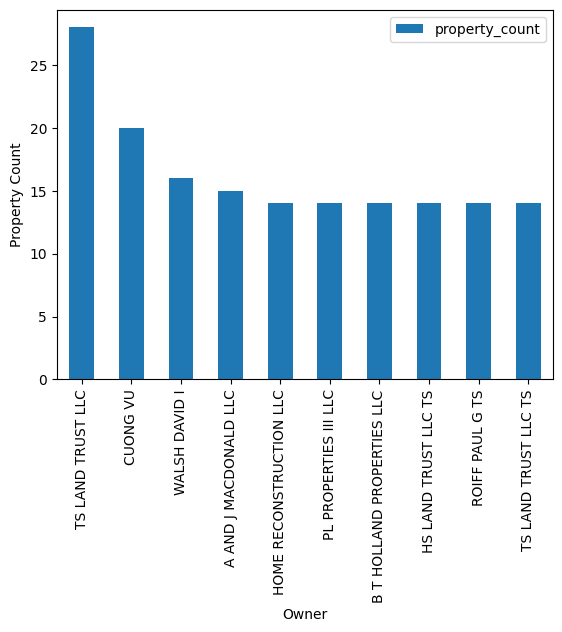

In [9]:
num_properties = rent_by_landlord.sort_values('property_count', ascending=False).head(10)
num_properties.plot.bar(x='owner_list', y='property_count', ylabel="Property Count", xlabel="Owner")

#highest_renters = rent_by_landlord.sort_values('total_possible_income', ascending=False).head(10)
#highest_renters.plot.bar(x="owner_list", y="total_possible_income", ylabel="Total Possible Income", xlabel="Owner")

# index = num_properties['owner_list'].tolist()
# avg_cost = num_properties['average_rent_price'].tolist()
# total_income = num_properties['total_possible_income'].tolist()
# property_count = num_properties['property_count'].tolist()

#graph_df = pd.DataFrame({#'average_rent_price': avg_cost,
#                   'total_possible_income': total_income, 
#                   'property_count': property_count},
#                   index=index)
#axes = graph_df.plot.bar(rot=0, subplots=True, figsize=(35, 20), fontsize=12)



In [125]:
rentsmart = pd.read_csv('./data/RentSmart-Data.csv')
rentsmart = rentsmart[rentsmart['violation_type'] != 'Enforcement Violations']
rentsmart['address'] = rentsmart['address'].apply(lambda x: x.split(',')[0].upper())
rentsmart = rentsmart.drop(['parcel', 'year built', 'year remodeled', 'property_type'], axis=1)
rentsmart.head()


,date,violation_type,description,address,neighborhood,zip_code,owner,latitude,longitude
59,2022-10-26 23:44:54.85,Sanitation Requests,Abandoned Vehicles,437 D ST,Boston,2210,FOUR 37 D STREET CONDOMINIUM TRUST,42.345160,-71.042990
60,2022-10-26 23:15:52.05,Sanitation Requests,Rodent Activity,21 WORCESTER SQ,Roxbury,2118,SEVENTEEN-21 WORCESTER SQ,42.336370,-71.074800
61,2022-10-26 22:58:03.23,Sanitation Requests,Rodent Activity,9 STILLMAN ST,Boston,2113,DEROSA LUCIA,42.363800,-71.056210
62,2022-10-26 22:40:33.91,Sanitation Requests,Rodent Activity,76 SALEM ST,Boston,2113,DAMORE PROPERTIES LLC,42.363590,-71.056030
63,2022-10-26 20:09:18.543,Sanitation Requests,Empty Litter Basket,108 CHARLES ST,Boston,2114,ONE 06-108 CHARLES ST CD TR,42.358895,-71.070901


In [209]:
merged_df = rentsmart.merge(zillow, right_on='Address', left_on='address')

merged_df.drop(
    merged_df.columns.difference(
        [
            'Property type', 'Address', 'City', 'date', 'violation_type', 'Rental Price (USD per month)',
            'description', 'zip_code', 'owner', 'latitude', 'longitude'
        ]
        ), 1, inplace=True)
merged_df.drop_duplicates(inplace=True)

merged_df = rent_by_landlord.merge(merged_df, right_on='owner', left_on='owner_list', how="left")
# merged_df.drop(['owner_list_x', 'total_possible_income_x', 'average_rent_price_x', 'property_count_x', 'owner_list_y', 'total_possible_income_y', 'average_rent_price_y', 'property_count_y','owner_list'], 
#                 inplace=True,
#                 axis = 1
#               )
merged_df.sort_values(by='total_possible_income', ascending=False).head()
merged_df['current_missed_income'] = merged_df.groupby('owner')['Rental Price (USD per month)'].transform('sum')
#merged_df.head()
#print(len(merged_df.index))

C:\Users\david\AppData\Local\Temp\ipykernel_19260\2587396009.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  merged_df.drop(


In [210]:
merged_df.rename(columns={"Rental Price (USD per month)": "rent"}, inplace=True)
merged_df['total_violation_count'] = merged_df.groupby('owner').owner.transform('count')
#merged_df.columns
merged_df['total_area_violations'] = merged_df.groupby('City').City.transform('count')
#merged_df['total_area_violations'] = merged_df['total_area_violations'].apply(lambda x: (x - merged_df['total_area_violations'].mean()) / merged_df['total_area_violations'].std())
merged_df['area_listing_count'] = merged_df.groupby('City').rent.transform('count')
merged_df.sort_values(by='owner', ascending=True).head(10)
#merged_df[merged_df['rent'].isna() & merged_df['date'].notna() & merged_df['City'].notna()].head()

,owner_list,total_possible_income,average_rent_price,property_count,date,violation_type,description,zip_code,owner,latitude,longitude,Property type,Address,City,rent,current_missed_income,total_violation_count,total_area_violations,area_listing_count
391,276 PARKER HILL LLP,24600.0,24600.000000,1,2022-01-31 11:18:00,Housing Complaints,No Utilities Residential - Water,2120.0,276 PARKER HILL LLP,42.32823,-71.09963,Apartment,278 PARKER HILL AVE,Roxbury Crossing,6800.0,13600.0,2.0,31.0,31.0
392,276 PARKER HILL LLP,24600.0,24600.000000,1,2018-09-01 14:14:00,Housing Complaints,Unsatisfactory Living Conditions,2120.0,276 PARKER HILL LLP,42.32823,-71.09963,Apartment,278 PARKER HILL AVE,Roxbury Crossing,6800.0,13600.0,2.0,31.0,31.0
1409,94 COWPER STREET LLC,7600.0,7600.000000,1,2019-12-20 15:04:00,Housing Complaints,"Heat - Excessive, Insufficient",2128.0,94 COWPER STREET LLC,42.38089,-71.01708,Apartment,94 COWPER ST,Boston,2300.0,11500.0,5.0,92.0,92.0
1408,94 COWPER STREET LLC,7600.0,7600.000000,1,2020-01-21 10:37:00,Housing Complaints,Maintenance Complaint - Residential,2128.0,94 COWPER STREET LLC,42.38089,-71.01708,Apartment,94 COWPER ST,Boston,2300.0,11500.0,5.0,92.0,92.0
1410,94 COWPER STREET LLC,7600.0,7600.000000,1,2019-05-13 12:11:00,Housing Complaints,Cross Metering - Sub-Metering,2128.0,94 COWPER STREET LLC,42.38089,-71.01708,Apartment,94 COWPER ST,Boston,2300.0,11500.0,5.0,92.0,92.0
1407,94 COWPER STREET LLC,7600.0,7600.000000,1,2020-11-19 10:01:00,Civic Maintenance Requests,Utility Casting Repair,2128.0,94 COWPER STREET LLC,42.38089,-71.01708,Apartment,94 COWPER ST,Boston,2300.0,11500.0,5.0,92.0,92.0
1411,94 COWPER STREET LLC,7600.0,7600.000000,1,2019-04-04 15:16:00,Housing Complaints,Cross Metering - Sub-Metering,2128.0,94 COWPER STREET LLC,42.38089,-71.01708,Apartment,94 COWPER ST,Boston,2300.0,11500.0,5.0,92.0,92.0
181,ALPGENE LLC,142100.0,12918.181818,11,2021-10-12 11:54:00,Sanitation Requests,Rodent Activity,2120.0,ALPGENE LLC,42.33000,-71.10317,Apartment,7 IROQUOIS ST,Boston,4300.0,15300.0,3.0,92.0,92.0
182,ALPGENE LLC,142100.0,12918.181818,11,2020-02-05 08:27:00,Housing Complaints,Chronic Dampness/Mold,2120.0,ALPGENE LLC,42.33080,-71.10507,Apartment,128 HILLSIDE ST,Roxbury Crossing,5500.0,15300.0,3.0,31.0,31.0
183,ALPGENE LLC,142100.0,12918.181818,11,2020-02-05 08:27:00,Housing Complaints,Chronic Dampness/Mold,2120.0,ALPGENE LLC,42.33080,-71.10507,Townhouse,128 HILLSIDE ST,Roxbury Crossing,5500.0,15300.0,3.0,31.0,31.0


In [184]:
per_ownerDF = merged_df[['owner', 'total_possible_income', 'average_rent_price', 'property_count', 'current_missed_income', 'total_violation_count', 'latitude', 'longitude']]
per_ownerDF = per_ownerDF.drop_duplicates()
per_ownerDF['current_income'] = per_ownerDF['total_possible_income'] - per_ownerDF['current_missed_income']
per_ownerDF['current_income'] = per_ownerDF['current_income'].apply(lambda x: 0 if x < 0 else x)
per_ownerDF['percent_income'] = (per_ownerDF['current_income'] / per_ownerDF['total_possible_income']) * 100
per_ownerDF['violation_bracket'] = per_ownerDF['total_violation_count'].apply(
    lambda x: '0-2' if x <= 2 
    else '3-4' if x > 2 and x <= 4
    else '5-6' if x > 4 and x <= 6
    else '7-8' if x > 6 and x <= 8
    else '9+'
    )
per_ownerDF.sort_values('total_violation_count', ascending=False).head()

,owner,total_possible_income,average_rent_price,property_count,current_missed_income,total_violation_count,latitude,longitude,current_income,percent_income,violation_bracket
11684,OCONNOR BREDA,13200.0,6600.000000,2,23375.0,10.0,42.29716,-71.07570,0.0,0.000000,9+
19327,GBM PORTFOLIO OWNER LLC,16000.0,5333.333333,3,18900.0,9.0,42.26387,-71.10393,0.0,0.000000,9+
3046,GIANGREGORIO GIOVANNI BE,8500.0,8500.000000,1,48000.0,8.0,42.36605,-71.03506,0.0,0.000000,7-8
9944,NGUYEN DUNG T,5500.0,5500.000000,1,48000.0,8.0,42.30349,-71.05872,0.0,0.000000,7-8
6935,REAL ESTATE BOSTON LLC,104500.0,9500.000000,11,26460.0,7.0,42.33570,-71.08353,78040.0,74.679426,7-8


<AxesSubplot: title={'center': 'Percent of Income Made Based on Violation Count'}, xlabel='Violation Bracket', ylabel='Mean Percent of Income'>

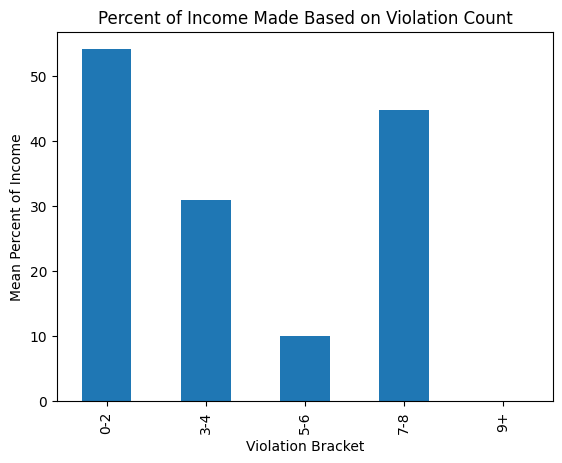

In [185]:
per_ownerDF.groupby('violation_bracket').percent_income.mean().plot.bar(title="Percent of Income Made Based on Violation Count", xlabel="Violation Bracket", ylabel="Mean Percent of Income")


In [88]:
per_ownerDF = per_ownerDF[per_ownerDF['property_count'] >= 3]
per_ownerDF = per_ownerDF.sort_values('total_violation_count', ascending=False)
per_ownerDF.head()
#sns.lmplot(x='percent_income',y='total_violation_count',data=per_ownerDF,fit_reg=True) 


,owner,total_possible_income,average_rent_price,property_count,current_missed_income,total_violation_count,current_income,percent_income,violation_bracket
6935,REAL ESTATE BOSTON LLC,104500.0,9500.000000,11,26460.0,7.0,78040.0,74.679426,7-8
5209,ROIFF PAUL G TS,104600.0,7471.428571,14,31200.0,6.0,73400.0,70.172084,5-6
9842,NGUYEN LY N,29600.0,7400.000000,4,9600.0,4.0,20000.0,67.567568,3-4
25274,KEANE THEODORE,66600.0,13320.000000,5,8400.0,4.0,58200.0,87.387387,3-4
51,ROIFF PAUL G,92000.0,9200.000000,10,13200.0,3.0,78800.0,85.652174,3-4


In [211]:
merged_df['total_area_violations'] =  (merged_df['total_area_violations'] - merged_df['total_area_violations'].mean())  / merged_df['total_area_violations'].std()
city_violations = merged_df[['City', 'total_area_violations', 'area_listing_count']]
heat_df = merged_df[['total_area_violations', 'area_listing_count', 'latitude', 'longitude']]
city_violations.dropna(inplace=True)
city_violations.drop_duplicates(inplace=True)
heat_df.dropna(inplace=True)
heat_df.drop_duplicates(inplace=True)
city_violations.head()

#city_violations[['total_area_violations', 'City']].plot.bar(x="City", y="total_area_violations")
#city_violations.head()
#sns.lmplot(x='total_area_violations',y='area_listing_count',data=merged_df,fit_reg=True) 

C:\Users\david\AppData\Local\Temp\ipykernel_19260\3667539499.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_violations.dropna(inplace=True)
C:\Users\david\AppData\Local\Temp\ipykernel_19260\3667539499.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_violations.drop_duplicates(inplace=True)
C:\Users\david\AppData\Local\Temp\ipykernel_19260\3667539499.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heat_df.dropna(in

,City,total_area_violations,area_listing_count
51,Roxbury Crossing,-0.476908,31.0
84,East Boston,-1.205053,5.0
123,Roxbury,-1.065025,10.0
150,Boston,1.231431,92.0
715,Mattapan,-1.261064,3.0
